# PDF

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, beta
from scipy.optimize import curve_fit
import emcee
import corner

In [3]:
def log_prior(x, a, b):
  return beta.logpdf(x, a, b)

def log_likelihood(x, mu, sigma):
  return norm.logpdf(x, mu, sigma)

def log_posterior(x, priors, pars):
  lp = log_prior(x, *priors)
  return lp + log_likelihood(x, *pars)

## Grid Method

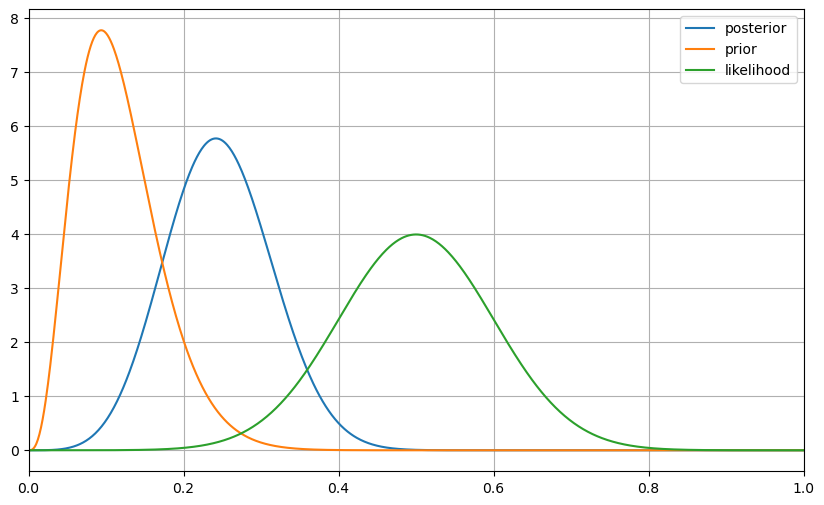

In [4]:
x = np.linspace(0, 1, 1000)
priors = 4, 30
pars = 0.5, 0.1
y = np.exp(log_posterior(x, priors, pars))
y = y / y.sum() / (x[1] - x[0])
y_prior = np.exp(log_prior(x, *priors))
y_likelihood = np.exp(log_likelihood(x, *pars))

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='posterior')
plt.plot(x, y_prior, label='prior')
plt.plot(x, y_likelihood, label='likelihood')
plt.grid()
plt.xlim(0, 1)
plt.legend()
plt.show()

## Gaussian Quadrature

[0.24368418 0.06918165 0.0187213 ]


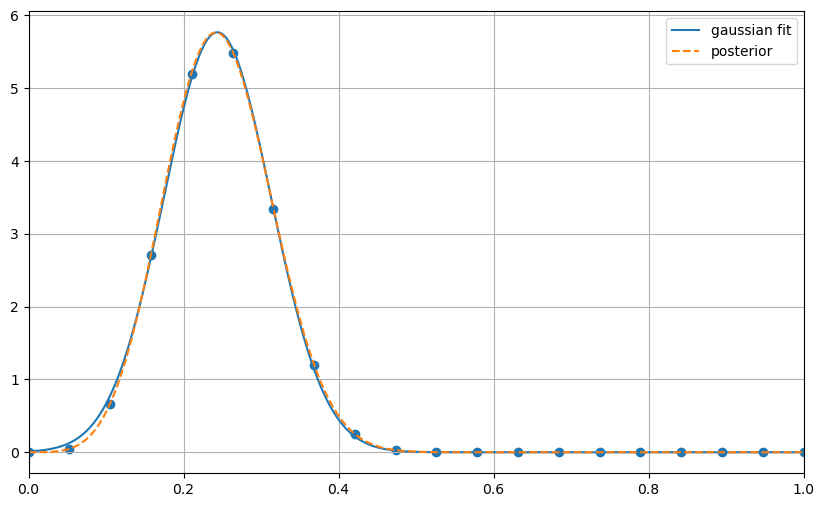

In [5]:
def gaussian(x, mu, sigma, A):
  return norm.pdf(x, mu, sigma)*A

x_s = np.linspace(0, 1, 20)
y_post = np.exp(log_posterior(x_s, priors, pars))
# y_post = y_post / y_post.sum() / (x_s[1] - x_s[0])
# y_post = np.exp(log_likelihood(x_s, *pars))

popt, pcov = curve_fit(gaussian, x_s, y_post, p0=(0.5, 0.1, 0.1))
print(popt)
y_fit = gaussian(x, *popt)
normalization = y_fit.sum() * (x[1] - x[0])
y_fit /=  normalization
y_post /=  normalization

plt.figure(figsize=(10, 6))
plt.scatter(x_s, y_post)
plt.plot(x, y_fit, label='gaussian fit')
plt.plot(x, y, label='posterior', linestyle='--')
plt.grid()
plt.xlim(0, 1)
plt.legend()
plt.show()

## MCMC

### emcee

In [6]:
ndim, nwalkers = 1, 5
priors = 4, 30
pars = 0.5, 0.1
p0 = uniform.rvs(0, 1, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, pars])
state = sampler.run_mcmc(p0, 1000, progress=True)

100%|██████████| 1000/1000 [00:03<00:00, 267.25it/s]


Text(0.5, 0, 'step number')

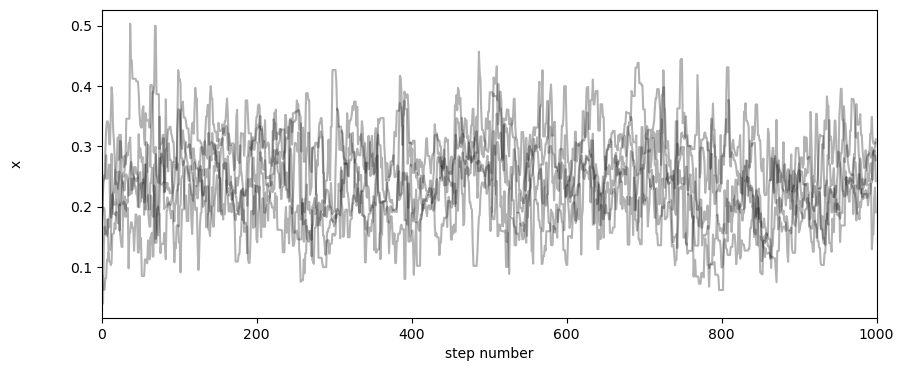

In [7]:
fig, axes = plt.subplots(1, figsize=(10, 4), sharex=True)
axes = [axes]
samples = sampler.get_chain()
labels = ["x"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [8]:
sampler.run_mcmc(state, 10000, progress=True)


100%|██████████| 10000/10000 [00:29<00:00, 339.61it/s]


State([[0.26114347]
 [0.3439058 ]
 [0.19231365]
 [0.26321578]
 [0.28846318]], log_prob=[-2.26825694 -3.25319357 -2.48397508 -2.27671271 -2.4471549 ], blobs=[], random_state=('MT19937', array([ 863790353, 2489676708, 1750702850, 1505001663, 3509406323,
       2482695220,  874927195,  443235925, 2637321915, 4241114064,
       1366165131, 4117822246, 2820997940, 1705731654, 4091874939,
        618883110, 1343225988, 2021055644,  249738500, 1000076984,
       3904952156, 2431912258, 1427849730,  465778709, 3340265885,
       1379091456, 3948870143, 1539308453, 1881119562, 3561436034,
        971006962, 3657324127, 2057190547, 3483440855,  579939127,
       1401829121, 3090141821, 3427314896, 2360167122, 1938487274,
       2001301375, 3126438021, 1164477732, 3228475720, 1546572609,
       3706965676, 2430220163, 3354590659, 3376053939, 4050280562,
       3125165922, 2927120598, 2850737734, 3615435460, 1953659896,
        751803119, 2219970849,  632095319, 2716263005, 1796274643,
       2087

Text(0.5, 0, 'step number')

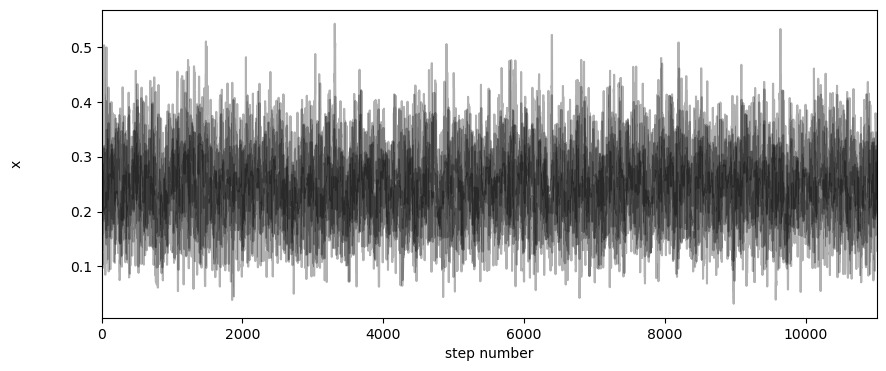

In [9]:
fig, axes = plt.subplots(1, figsize=(10, 4), sharex=True)
axes = [axes]
samples = sampler.get_chain()
labels = ["x"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

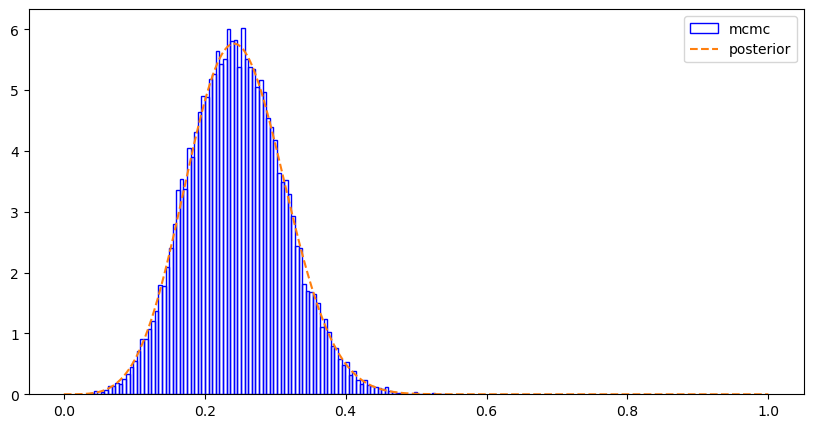

In [18]:
plt.figure(figsize=(10,5))
plt.hist(samples[:, :, 0].flatten(), bins=100, density=True, facecolor="none", ec="blue", label="mcmc")
plt.plot(x, y, label='posterior', linestyle='--')
plt.legend()
plt.show()

# 5 parameters

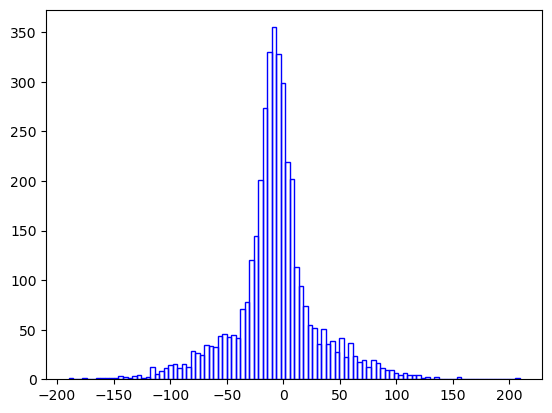

In [38]:
sigma1 = 11
sigma2 = 50
w0 = -7
N = 2000

w1 = norm.rvs(w0, sigma1, size=N)
w2 = norm.rvs(w0, sigma2, size=N)

w = np.concatenate((w1, w2), axis=0)

plt.figure()
plt.hist(w, bins=100, facecolor="none", ec="blue")
# plt.yscale("log")
plt.show()

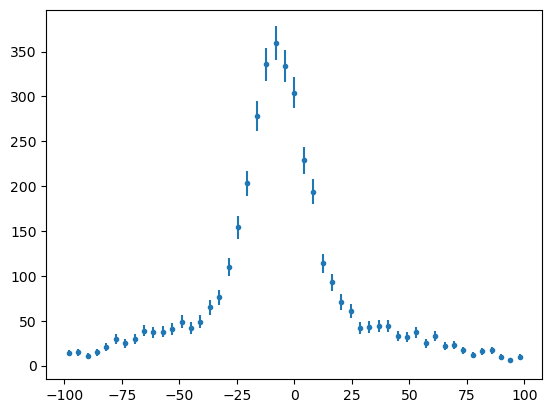

In [51]:
we = np.linspace(-100, 100, 50)
ws = (we[:-1]+we[1:])/2
fw, _ = np.histogram(w, bins=we)
fe = np.sqrt(fw)

plt.figure()
plt.errorbar(ws, fw, fe, fmt=".")
plt.show()

In [67]:
def log_prior(pars, priors):
  locs, scales = priors
  result = np.sum(uniform.logpdf(pars, loc=locs, scale=scales))
  return result


pars = 11, 50, -7, 5000, 2000
locs = 5, 45, -10, 1500, 1500
scales = 10, 10, 5, 1000, 1000
priors = locs, scales

log_prior(pars, priors)

-20.030118656386467

In [82]:
def gaussian(x, mu, sigma, A):
  return norm.pdf(x, mu, sigma)*A

def log_likelihood(pars, data):
  ws, fw, fe = data
  sigma1, sigma2, w0, N1, N2 = pars
  fmod = gaussian(ws, w0, sigma1, N1)+gaussian(ws, w0, sigma2, N2)
  result = np.sum(norm.logpdf(fmod, loc=fw, scale=fe))
  return result

data = ws, fw, fe
log_likelihood(pars, data)

-1251.0542703219478

In [59]:
def log_posterior(x, priors, data):
  pars = x[0], x[1], x[2], x[3], x[4]
  log_prior_ = log_prior(pars, priors)
  if not np.isfinite(log_prior_):
    return -np.infty
  return log_prior_ + log_likelihood(pars, data)

x = list(pars)
log_posterior(x, priors, data)

-1268.7818038853402

In [105]:
ndim = 5
nwalkers = ndim*2+1

# pars = 11, 50, -7, 2000, 2000
locs = 5, 40, -10, 5000, 5000
scales = 10, 20, 5, 5000, 5000
priors = locs, scales

data = ws, fw, fe

sigma1_0 = uniform.rvs(locs[0], scales[0], size=(nwalkers))
sigma2_0 = uniform.rvs(locs[1], scales[1], size=(nwalkers))
w0_0 = uniform.rvs(locs[2], scales[2], size=(nwalkers))
N1_0 = uniform.rvs(locs[3], scales[3], size=(nwalkers))
N2_0 = uniform.rvs(locs[4], scales[4], size=(nwalkers))

p0 = np.array([sigma1_0, sigma2_0, w0_0, N1_0, N2_0]).T

In [106]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, data])
state = sampler.run_mcmc(p0, 1000, progress=True)

100%|██████████| 1000/1000 [00:05<00:00, 171.77it/s]


Text(0.5, 0, 'step number')

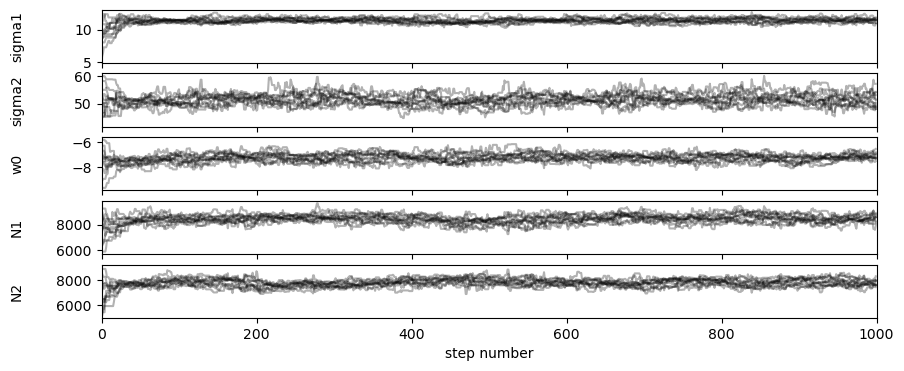

In [107]:
fig, axes = plt.subplots(5, figsize=(10, 4), sharex=True)
# axes = [axes]
samples = sampler.get_chain()
labels = ["sigma1", "sigma2", "w0", "N1", "N2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [108]:
sampler.reset()
state = sampler.run_mcmc(state, 10000, progress=True)

100%|██████████| 10000/10000 [01:03<00:00, 157.69it/s]


Text(0.5, 0, 'step number')

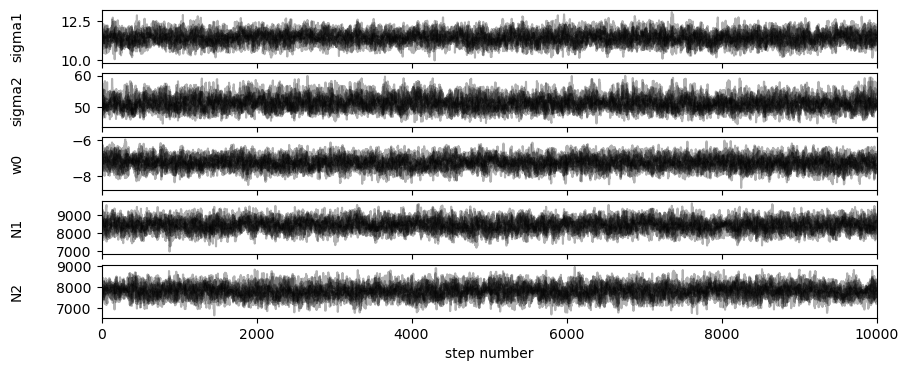

In [109]:
fig, axes = plt.subplots(5, figsize=(10, 4), sharex=True)
# axes = [axes]
samples = sampler.get_chain()
labels = ["sigma1", "sigma2", "w0", "N1", "N2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

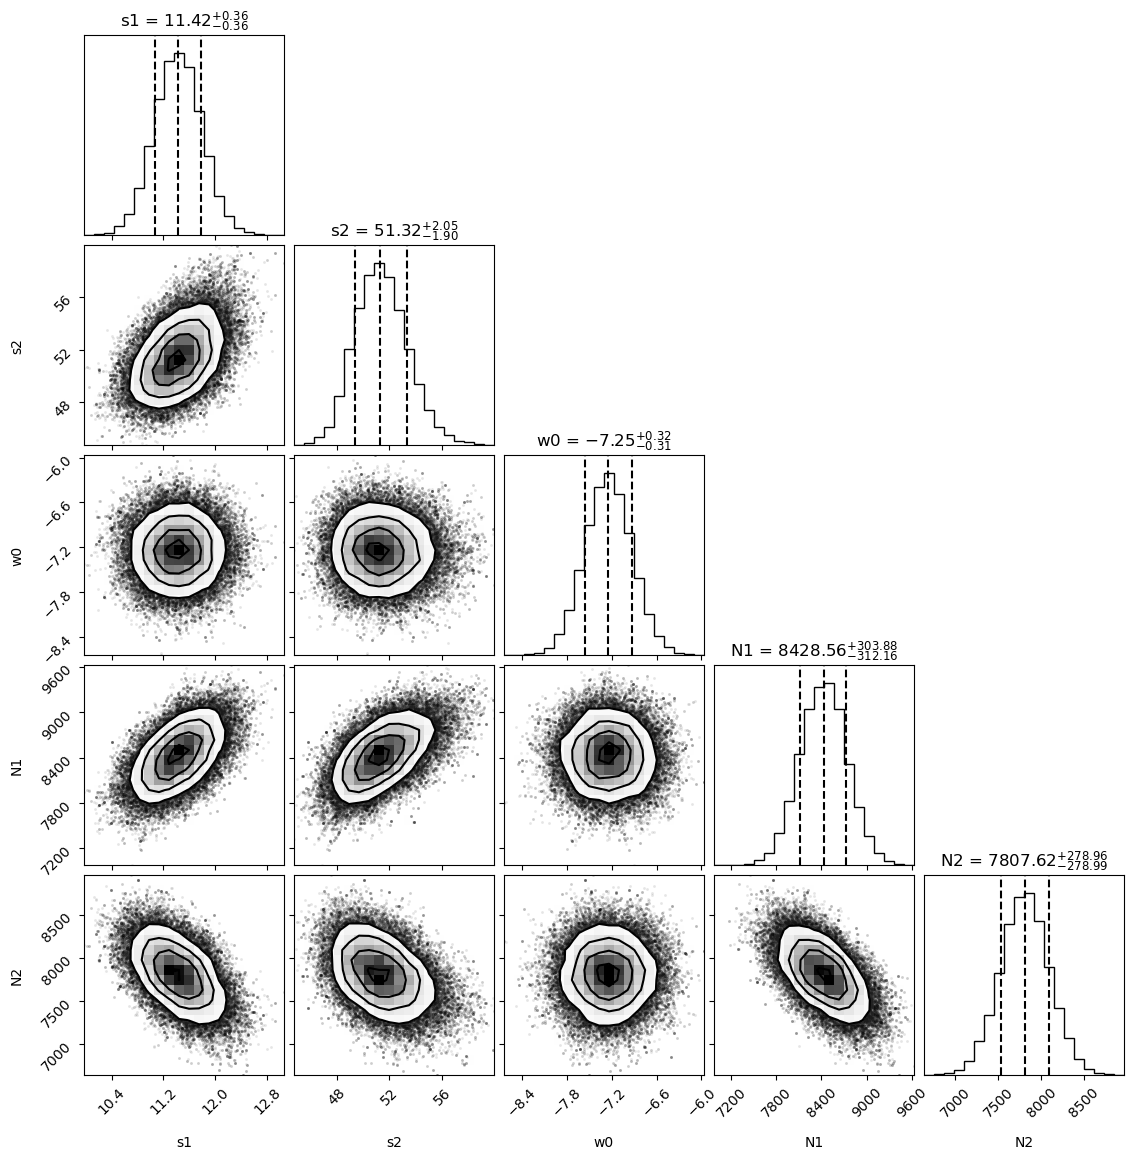

In [111]:
samples = sampler.get_chain(flat=True)

figure = corner.corner(
  samples, 
  labels=["s1", "s2", "w0", "N1", "N2"],
  quantiles=[0.16, 0.5, 0.84],
  show_titles=True,
  title_kwargs={"fontsize": 12},
)

In [112]:
model = dict(
    sigma1=samples[:, 0],
    sigma2=samples[:, 1],
    w0=samples[:, 2],
    N1=samples[:, 3],
    N2=samples[:, 4],
)
total = len(samples[:, 0])

theta = dict(
    sigma1=samples[-1, 0],
    sigma2=samples[-1, 1],
    w0=samples[-1, 2],
    N1=samples[-1, 3],
    N2=samples[-1, 4],
)

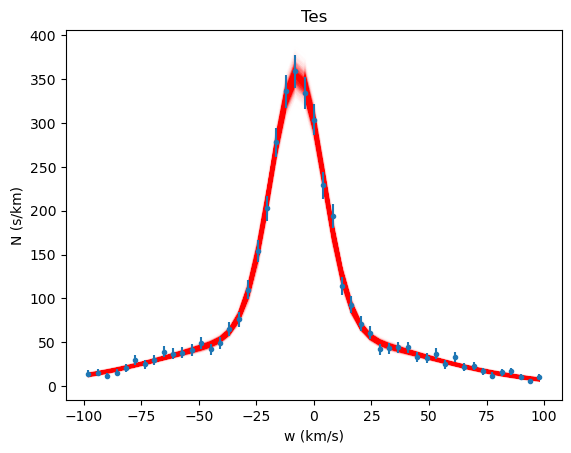

In [113]:
plt.figure()
plt.title("Tes")
fmodel = lambda x, t: gaussian(x, t["w0"], t["sigma1"], t["N1"]) + gaussian(x, t["w0"], t["sigma2"], t["N2"])

for i in range(2000):
    index = int(np.random.random()*total)
    for k, v in model.items():
        theta[k] = v[index]
    fm = fmodel(ws, theta)
    plt.plot(ws, fm, c="red", alpha=0.002)
plt.errorbar(ws, fw, yerr=fe, fmt='.')
plt.xlabel("w (km/s)")
plt.ylabel("N (s/km)")
plt.show()